In [6]:
import seaborn as sns
import os
from scipy.stats import kurtosis, skew
import pickle
import numpy as np
import matplotlib.pyplot as plt

from rcv_distribution import *
from MDS_analysis import *
from voting_rules import *
import random
from itertools import permutations
from collections import defaultdict
from collections import Counter

In [5]:
def normalize_data(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

Albany_11082022_FAKECityCouncil.csv   list index out of range
[[-2.10873215e-02  9.35119363e-01  5.38477850e-01  5.78490465e-01
   9.99593057e-01  8.97567820e-01  3.82756276e-01  5.23416172e-01
   4.09676187e-01  9.98839151e-01  8.46288698e-01  9.34562901e-01
   2.66862827e-01  1.01957434e+00  1.02321142e+00  1.05107207e+00
  -4.78469676e-02  6.60465808e-01  6.95906970e-02  1.99049160e-01
   1.01758119e+00  6.22580397e-01  9.78100157e-01 -3.54529617e-02
   9.39612449e-01 -4.36309661e-02 -3.87556492e-02  2.31745553e-01
   1.01739813e+00 -3.93149515e-02  2.43008787e-02  9.99229688e-03
   9.55983759e-01  7.77380432e-01  9.63363511e-02  5.29948989e-01
   7.55110739e-01  7.21763554e-01  1.86958293e-01  9.56035676e-02
   7.60521820e-01  6.90908746e-02 -2.44909625e-02  2.71260394e-01
   7.62839741e-01  1.25951575e-01  1.00193082e+00 -2.45005103e-04
   1.69895863e-01  3.31946697e-02  7.45866347e-02  1.01576890e+00
  -1.56963437e-02  2.37342042e-01  5.72858889e-02  5.84370827e-01
   6.53923433e

ValueError: x and y must be the same size

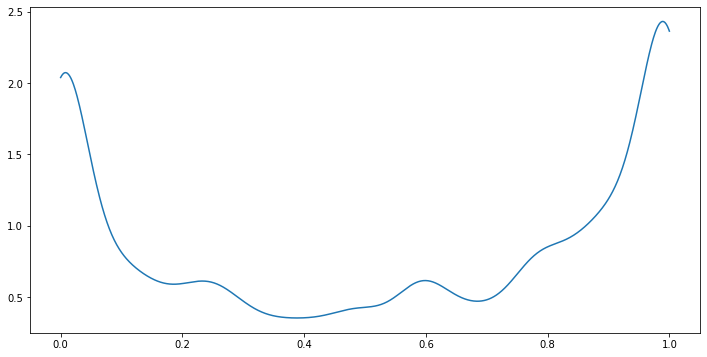

In [33]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde


directory = "np_data_new"
df = pd.read_csv("median_voter_analysis.csv")
partisan_data = {'YES': [], 'NO': []}

for file in os.listdir(directory):
    try:
        filename = file[0:-4] + ".csv"
        if df.loc[df["filename"] == filename, "#candidates"].tolist()[0] > 2:
            data = np.load(os.path.join(directory, file))

            # Normalize the data
            data = normalize_data(data)

            partisan = df.loc[df["filename"] == filename, "partisan"].tolist()[0]
            if partisan in partisan_data:
                partisan_data[partisan].extend(data)  # Accumulate the normalized data

    except Exception as e:
        print(filename, " ", e)

# Calculate and plot KDEs for the accumulated data
plt.figure(figsize=(12, 6))
sampled_points = {}
for key, data in partisan_data.items():
    if data:  # Check if there is data for the group
        kde = gaussian_kde(data, bw_method=0.1)
        x = np.linspace(np.min(data), np.max(data), 1000)
        kde_values = kde(x)
        
        # Plot the KDE
        plt.plot(x, kde_values, label=f'KDE {key}')
        
        # Sample 1000 points from the KDE
        sampled_points[key] = kde.resample(size=1000)
        print(sampled_points[key])
        # Plot the sampled points
        plt.scatter(sampled_points[key], np.zeros_like(sampled_points) + np.max(kde_values) * 0.1, label=f'Sampled Points {key}', alpha=0.5)

plt.xlabel('Normalized Data')
plt.ylabel('Density')
plt.legend()
plt.title('KDE and Sampled Points')
plt.show()


In [643]:
def generate_permutations(items, k):
    all_permutations = []
    
    for length in range(1, k + 1):
        perms = permutations(items, length)
        all_permutations.extend(perms)
    
    return all_permutations

In [ ]:
# This function is generating totaly random ballots instead of the inconsistent ones (not keeping the first place choices)

def generate_random_inconsistent_ballots(ballots, candidates, filename):
    filename = filename + ".csv"
    election = pd.read_csv("election_table.csv")
    choices = min(len(candidates), round(election.loc[election['filename']==filename, 'choices'].values[0]))
    if choices == 1:
        choices = len(candidates)

    #print(choices)
    directory = "null_elections"
    csv = os.path.join(directory, filename) 
    df = pd.read_csv(csv)

    perms = generate_permutations(candidates, choices)

    normalized_distances = pd.Series(df['position'].values, index=df['candidate']).to_dict()
    #print(normalized_distances)
    consistent_ballots, gamma = get_permissive_gamma(ballots, normalized_distances)

    perms = [perm for perm in perms if (perm not in consistent_ballots) and is_consistent(perm, normalized_distances)==False]    
    
   
    all_voters = 0
    for b in ballots:
        if len(b) > 0:
            all_voters += ballots[b]
    consistent_voters = sum(consistent_ballots.values())
    inconsistent_voters = all_voters - consistent_voters
    inconsistent_ballots_list = random.choices(perms, k=inconsistent_voters)
    inconsistent_ballots = {}

    for ballot in inconsistent_ballots_list:
        if ballot not in inconsistent_ballots:
            inconsistent_ballots[ballot] = 0
        inconsistent_ballots[ballot] += 1

    return inconsistent_ballots, consistent_ballots
    

In [ ]:
def generate_ballots(data, candidates_positions):
    

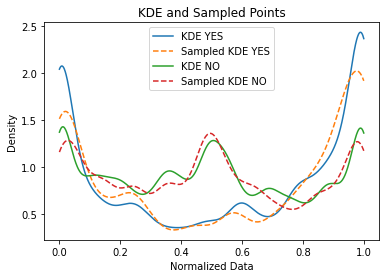

In [28]:
for key, data in partisan_data.items():
    if data:  # Check if there is data for the group
        kde = gaussian_kde(data, bw_method=0.1)
        x = np.linspace(np.min(data), np.max(data), 1000)
        kde_values = kde(x)
        
        # Plot the KDE
        plt.plot(x, kde_values, label=f'KDE {key}')
        
        # Sample 1000 points from the KDE
        sampled_points = kde.resample(size=1000)
        kde_sampled = gaussian_kde(sampled_points.flatten(), bw_method=0.1)
        kde_sampled_values = kde_sampled(x)
        
        # Plot the KDE of sampled points
        plt.plot(x, kde_sampled_values, '--', label=f'Sampled KDE {key}')
plt.xlabel('Normalized Data')
plt.ylabel('Density')
plt.legend()
plt.title('KDE and Sampled Points')
plt.show()


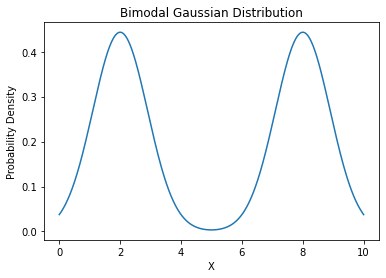

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Define the parameters for the two Gaussians
mu1, sigma1 = 2, 0.9
mu2, sigma2 = 8, 0.9

# Create a range of x values
x = np.linspace(0, 10, 1000)

# Create the bimodal distribution
y1 = norm.pdf(x, mu1, sigma1)
y2 = norm.pdf(x, mu2, sigma2)
y = y1 + y2

# Plot the bimodal distribution
plt.plot(x, y)
plt.title('Bimodal Gaussian Distribution')
plt.xlabel('X')
plt.ylabel('Probability Density')
plt.show()


In [42]:
# Split the x-axis into two halves
midpoint = len(x) // 2
x_left = x[:midpoint]
x_right = x[midpoint:]
y_left = y[:midpoint]
y_right = y[midpoint:]
# Generate 5 random points for each half
np.random.seed(0)  # For reproducibility
random_points_left = np.random.choice(x_left, 5, replace=False)
random_points_right = np.random.choice(x_right, 5, replace=False)


In [43]:
from scipy.integrate import quad

# Function to compute the area under the curve
def area_under_curve(x_val, x, y):
    idx = np.searchsorted(x, x_val)
    integral, _ = quad(lambda t: np.interp(t, x, y), x[0], x_val)
    return integral

# Calculate the area for each random point
areas_left = [area_under_curve(p, x, y) for p in random_points_left]
areas_right = [area_under_curve(p, x, y) for p in random_points_right]

# Combine points and areas
points = np.concatenate((random_points_left, random_points_right))
areas = np.concatenate((areas_left, areas_right))


C:\Users\mahsh\AppData\Local\Temp\ipykernel_13320\1560956951.py:6: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  integral, _ = quad(lambda t: np.interp(t, x, y), x[0], x_val)


In [44]:
# Define the number of top points to select
n = 3  # For example

# Get indices of the top n points with the highest areas
top_n_indices = np.argsort(areas)[-n:]

# Get the top n points and their corresponding areas
top_n_points = points[top_n_indices]
top_n_areas = areas[top_n_indices]

print("Top N Points:", top_n_points)
print("Top N Areas:", top_n_areas)


Top N Points: [7.77777778 8.07807808 9.36936937]
Top N Areas: [1.38935322 1.52143087 1.9227984 ]


Albany_11082022_FAKECityCouncil.csv   list index out of range


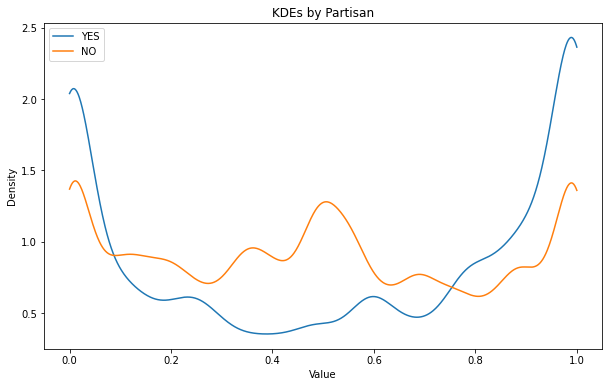

In [66]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

def normalize_data(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

directory = "np_data_new"
df = pd.read_csv("median_voter_analysis.csv")
partisan_data = {'YES': [], 'NO': []}

for file in os.listdir(directory):
    try:
        filename = file[0:-4] + ".csv"
        if df.loc[df["filename"] == filename, "#candidates"].tolist()[0] > 2:
            data = np.load(os.path.join(directory, file))

            # Normalize the data
            data = normalize_data(data)

            partisan = df.loc[df["filename"] == filename, "partisan"].tolist()[0]
            if partisan in partisan_data:
                partisan_data[partisan].extend(data)  # Accumulate the normalized data

    except Exception as e:
        print(filename, " ", e)

# Calculate and plot KDEs for the accumulated data
plt.figure(figsize=(10, 6))

for key, data in partisan_data.items():
    if data:  # Check if there is data for the group
        kde = gaussian_kde(data, bw_method=0.1)
        x = np.linspace(np.min(data), np.max(data), 1000)
        kde_values = kde(x)
        plt.plot(x, kde_values, label=key)

plt.xlabel('Value')
plt.ylabel('Density')
plt.title('KDEs by Partisan')
plt.legend()
plt.show()


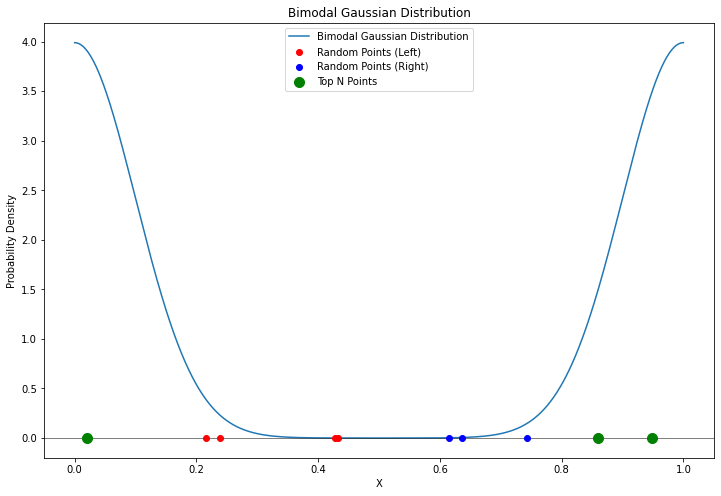

Top N Points: [0.85985986 0.94894895 0.02002002]
Top N Y-Values: [1.49433847 3.50200643 3.91027029]


In [100]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Step 1: Generate a Perfect Bimodal Gaussian
mu1, sigma1 = 0, 0.1
mu2, sigma2 = 1, 0.1
x = np.linspace(0, 1, 1000)
y1 = norm.pdf(x, mu1, sigma1)
y2 = norm.pdf(x, mu2, sigma2)
y = y1 + y2

plt.figure(figsize=(12, 8))

# Plot the bimodal distribution
plt.plot(x, y, label='Bimodal Gaussian Distribution')
plt.title('Bimodal Gaussian Distribution')
plt.xlabel('X')
plt.ylabel('Probability Density')

# Step 2: Divide the X-Axis into Two Halves
midpoint = len(x) // 2
x_left = x[:midpoint]
x_right = x[midpoint:]
y_left = y[:midpoint]
y_right = y[midpoint:]

# Step 3: Generate Random Points
#np.random.seed(0)  # For reproducibility
random_points_left = np.random.choice(x_left, 5, replace=False)
random_points_right = np.random.choice(x_right, 5, replace=False)


#random_points_left = np.append(random_points_left, 0)
#random_points_right = np.append(random_points_right, 1)

# Step 4: Calculate the Y-Values (Probability Density) at the Random Points
y_values_left = norm.pdf(random_points_left, mu1, sigma1) + norm.pdf(random_points_left, mu2, sigma2)
y_values_right = norm.pdf(random_points_right, mu1, sigma1) + norm.pdf(random_points_right, mu2, sigma2)

# Combine points and y-values
points = np.concatenate((random_points_left, random_points_right))
y_values = np.concatenate((y_values_left, y_values_right))

# Step 5: Select Top N Points
n = 3  # For example
top_n_indices = np.argsort(y_values)[-n:]
top_n_points = points[top_n_indices]
top_n_y_values = y_values[top_n_indices]

# Plot the selected random points on the x-axis
plt.axhline(0, color='black', linewidth=0.5)
plt.scatter(random_points_left, np.zeros_like(random_points_left), color='red', label='Random Points (Left)', zorder=5)
plt.scatter(random_points_right, np.zeros_like(random_points_right), color='blue', label='Random Points (Right)', zorder=5)
plt.scatter(top_n_points, np.zeros_like(top_n_points), color='green', s=100, label='Top N Points', zorder=5)
plt.legend()
plt.show()

print("Top N Points:", top_n_points)
print("Top N Y-Values:", top_n_y_values)


In [68]:
top_n_points = normalize_data(top_n_points)

Albany_11082022_FAKECityCouncil.csv   list index out of range


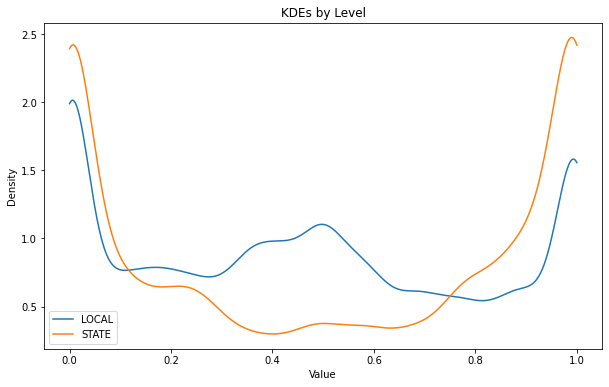

In [582]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

def normalize_data(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

directory = "np_data_new"
df = pd.read_csv("median_voter_analysis2.csv")
level_data = {'LOCAL': [], 'STATE': []}

for file in os.listdir(directory):
    filename = file[0:-4] + ".csv"
    try:
        data = np.load(os.path.join(directory, file))
        data = normalize_data(data)

        filename = file[0:-4] + ".csv"
        level = df.loc[df["filename"] == filename, "level"].tolist()[0]
        if level == 'FEDERAL':
            level = 'STATE'
        if level in level_data:
            level_data[level].extend(data)  # Accumulate the normalized data

    except Exception as e:
        print(filename, " ", e)

# Calculate and plot KDEs for the accumulated data
plt.figure(figsize=(10, 6))

"""data_local = level_data['LOCAL']
kde = gaussian_kde(data, bw_method=0.1)
x_local = np.linspace(np.min(data), np.max(data), 1000)
kde_values_local = kde(x)
plt.plot(x_local, kde_values_local, label=key)"""
for key, data in level_data.items():
    if key == 'LOCAL' and data:  # Check if there is data for the group
        kde = gaussian_kde(data, bw_method=0.1)
        x = np.linspace(np.min(data), np.max(data), 1000)
        kde_values = kde(x)
        plt.plot(x, kde_values, label=key)

plt.xlabel('Value')
plt.ylabel('Density')
plt.title('KDEs by Level')
plt.legend()
plt.show()


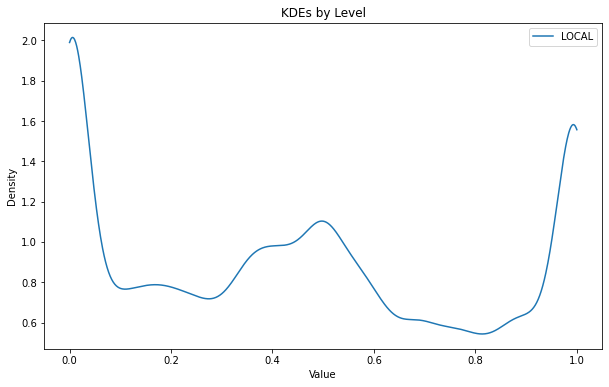

In [583]:
plt.figure(figsize=(10, 6))

"""data_local = level_data['LOCAL']
kde = gaussian_kde(data, bw_method=0.1)
x_local = np.linspace(np.min(data), np.max(data), 1000)
kde_values_local = kde(x)
plt.plot(x_local, kde_values_local, label=key)"""
for key, data in level_data.items():
    if key == 'LOCAL' and data:  # Check if there is data for the group
        kde = gaussian_kde(data, bw_method=0.1)
        x = np.linspace(np.min(data), np.max(data), 1000)
        kde_values = kde(x)
        plt.plot(x, kde_values, label=key)

plt.xlabel('Value')
plt.ylabel('Density')
plt.title('KDEs by Level')
plt.legend()
plt.show()

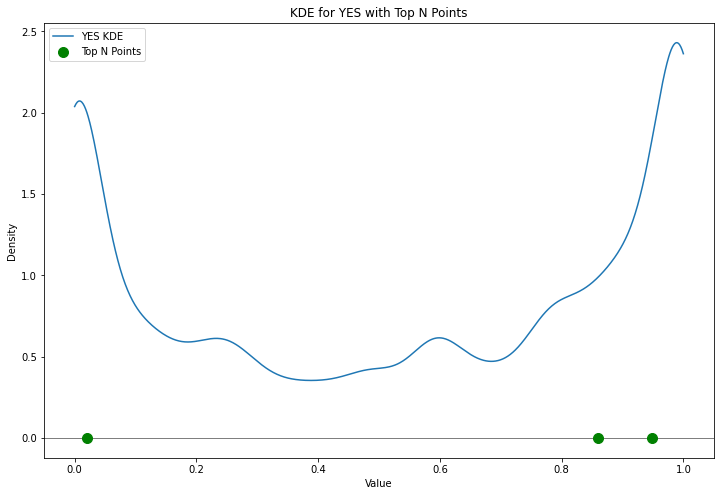

In [102]:
if partisan_data['YES']:
    kde_yes = gaussian_kde(partisan_data['YES'], bw_method=0.1)
    x_yes = np.linspace(np.min(partisan_data['YES']), np.max(partisan_data['YES']), 1000)
    kde_values_yes = kde_yes(x_yes)

    plt.figure(figsize=(12, 8))
    plt.plot(x_yes, kde_values_yes, label='YES KDE')
    plt.scatter(top_n_points, np.zeros_like(top_n_points), color='green', s=100, label='Top N Points', zorder=5)
    plt.axhline(0, color='black', linewidth=0.5)
    plt.title('KDE for YES with Top N Points')
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

In [542]:
kde_yes = gaussian_kde(partisan_data['YES'], bw_method=0.1)
x_yes = np.linspace(np.min(partisan_data['YES']), np.max(partisan_data['YES']), 1000)
kde_values_yes = kde_yes(x_yes)

In [556]:
kde_values = kde_values_yes / np.sum(kde_values)

# Compute the cumulative sum
cumulative_sum = np.cumsum(kde_values)

# Find the median
median_index = np.searchsorted(cumulative_sum, 0.5)
median_kde = x[median_index]

In [557]:
print(median_kde)

0.6956956956956957


In [554]:
cdf_yes = np.cumsum(kde_yes(x_yes)) * (x_yes[1] - x_yes[0])
median_index = np.argmin(np.abs(cdf_yes - 0.5))
median_value = x_yes[median_index]

In [555]:
print(median_value)

0.7757757757757757


In [549]:
mirrored_voter_data = 1 - voter_data
mirrored_voter_kde = gaussian_kde(mirrored_voter_data)
x_voter_mirrored = 1 - x_voter

TypeError: unsupported operand type(s) for -: 'int' and 'list'

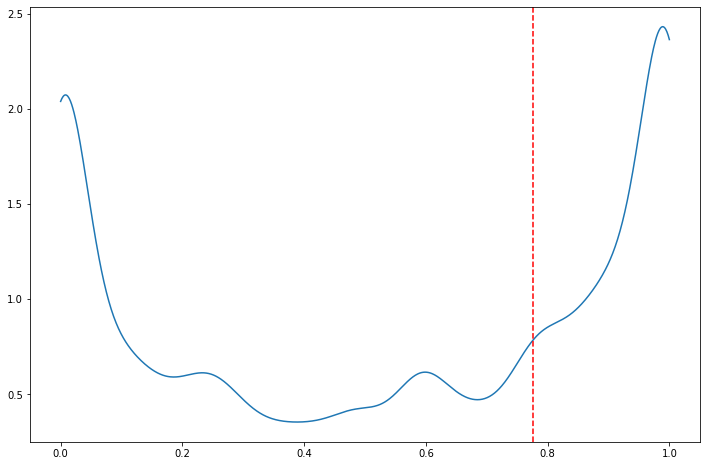

In [367]:
plt.figure(figsize=(12, 8))
plt.plot(x_yes, kde_values_yes, label='YES KDE')
plt.axvline(x=median_value, color='red', linestyle='--', label=f'Median Voter')

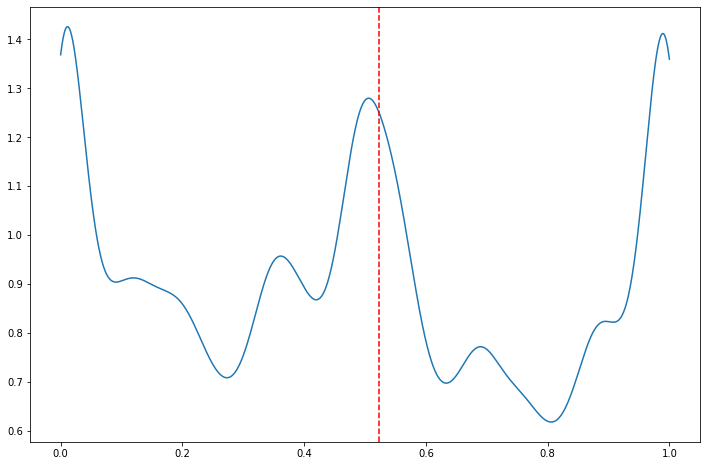

In [701]:
cdf_no = np.cumsum(kde_no(x_no)) * (x_no[1] - x_no[0])
median_index = np.argmin(np.abs(cdf_no - 0.5))
median_value = x_no[median_index]

plt.figure(figsize=(12, 8))
plt.plot(x_no, kde_values_no, label='Local')
plt.axvline(x=median_value, color='red', linestyle='--', label=f'Median Voter')

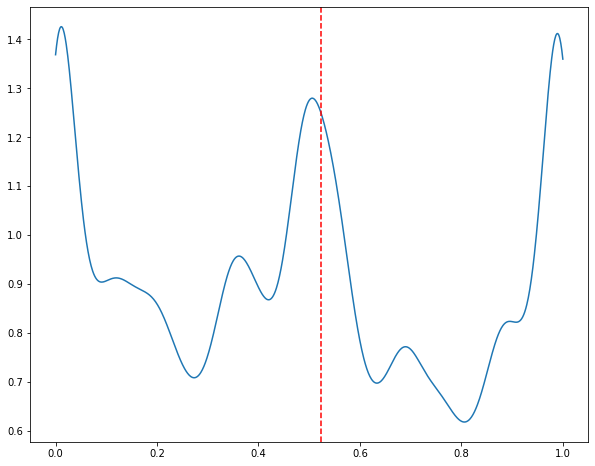

In [703]:
plt.figure(figsize=(10, 8))
plt.plot(x_no, kde_values_no, label='Local')
plt.axvline(x=median_value, color='red', linestyle='--', label=f'Median Voter')

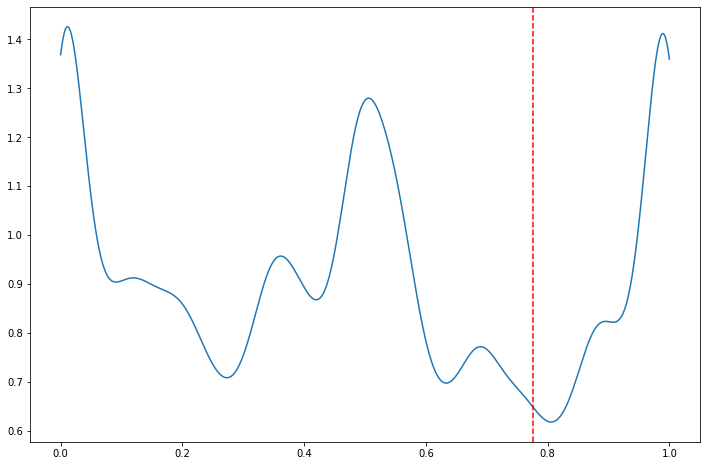

In [358]:
kde_no = gaussian_kde(partisan_data['NO'], bw_method=0.1)
x_no = np.linspace(np.min(partisan_data['NO']), np.max(partisan_data['NO']), 1000)
kde_values_no = kde_no(x_no)
cdf_no = np.cumsum(kde_no(x_no)) * (x_no[1] - x_no[0])
median_index_no = np.argmin(np.abs(cdf_no - 0.5))
median_value_no = x_no[median_index]
plt.figure(figsize=(12, 8))
plt.plot(x_no, kde_values_no, label='NO KDE')
plt.axvline(x=median_value, color='red', linestyle='--', label=f'Median Voter')

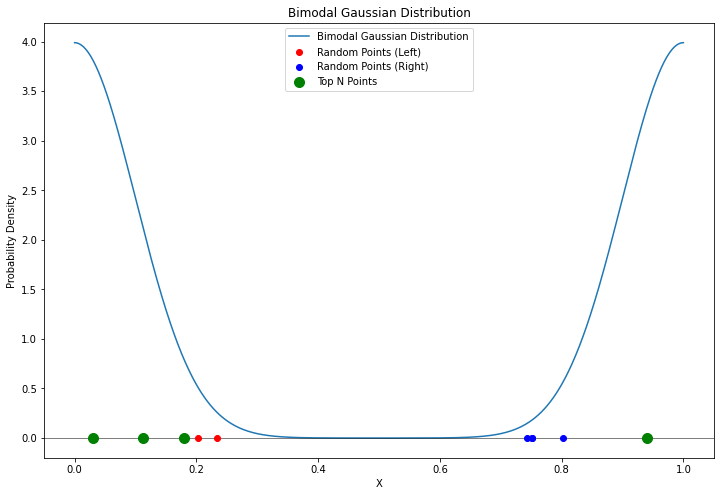

Top N Points: [0.17917918 0.11311311 0.93993994 0.03003003]
Top N Y-Values: [0.8012259  2.10416295 3.33104484 3.81353441]


In [159]:


import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Step 1: Generate a Perfect Bimodal Gaussian
mu1, sigma1 = 0, 0.1
mu2, sigma2 = 1, 0.1
x = np.linspace(0, 1, 1000)
y1 = norm.pdf(x, mu1, sigma1)
y2 = norm.pdf(x, mu2, sigma2)
y = y1 + y2

plt.figure(figsize=(12, 8))

# Plot the bimodal distribution
plt.plot(x, y, label='Bimodal Gaussian Distribution')
plt.title('Bimodal Gaussian Distribution')
plt.xlabel('X')
plt.ylabel('Probability Density')

# Step 2: Divide the X-Axis into Two Halves
midpoint = len(x) // 2
x_left = x[:midpoint]
x_right = x[midpoint:]
y_left = y[:midpoint]
y_right = y[midpoint:]

# Step 3: Generate Random Points
#np.random.seed(0)  # For reproducibility
random_points_left = np.random.choice(x_left, 5, replace=False)
random_points_right = np.random.choice(x_right, 5, replace=False)


#random_points_left = np.append(random_points_left, 0)
#random_points_right = np.append(random_points_right, 1)

# Step 4: Calculate the Y-Values (Probability Density) at the Random Points
y_values_left = norm.pdf(random_points_left, mu1, sigma1) + norm.pdf(random_points_left, mu2, sigma2)
y_values_right = norm.pdf(random_points_right, mu1, sigma1) + norm.pdf(random_points_right, mu2, sigma2)

# Combine points and y-values
points = np.concatenate((random_points_left, random_points_right))
y_values = np.concatenate((y_values_left, y_values_right))

# Step 5: Select Top N Points
n = 4  # For example
top_n_indices = np.argsort(y_values)[-n:]
top_n_points = points[top_n_indices]
top_n_y_values = y_values[top_n_indices]

# Plot the selected random points on the x-axis
plt.axhline(0, color='black', linewidth=0.5)
plt.scatter(random_points_left, np.zeros_like(random_points_left), color='red', label='Random Points (Left)', zorder=5)
plt.scatter(random_points_right, np.zeros_like(random_points_right), color='blue', label='Random Points (Right)', zorder=5)
plt.scatter(top_n_points, np.zeros_like(top_n_points), color='green', s=100, label='Top N Points', zorder=5)
plt.legend()
plt.show()

print("Top N Points:", top_n_points)
print("Top N Y-Values:", top_n_y_values)




In [177]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

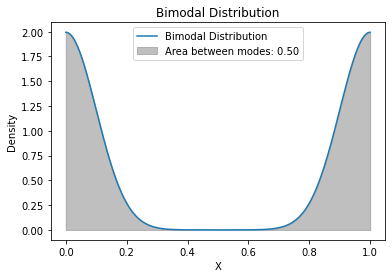

In [463]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.optimize import minimize

# Define parameters
width1 = 0.1     # Width (standard deviation) of the first peak
width2 = 0.1     # Width (standard deviation) of the second peak
area_between = 0.9  # Desired area between the two peaks

# Means of the peaks
mean1 = 0
mean2 = 1

# Create the distributions
dist1 = norm(loc=mean1, scale=width1)
dist2 = norm(loc=mean2, scale=width2)

# Define the mixture distribution
def mixture_distribution(x, height1, height2):
    return height1 * dist1.pdf(x) + height2 * dist2.pdf(x)

# Normalize the distribution
def normalize_distribution(x, height1, height2):
    total_area, _ = quad(lambda x: mixture_distribution(x, height1, height2), -np.inf, np.inf)
    return mixture_distribution(x, height1, height2) / total_area

# Define the area between the two modes
def area_between_modes(height1, height2):
    area, _ = quad(lambda x: normalize_distribution(x, height1, height2), mean1, mean2)
    return area

# Objective function to minimize
def objective_function(params):
    height1, height2 = params
    return abs(area_between_modes(height1, height2) - area_between)

# Initial guess for heights
initial_heights = [1, 1]

# Perform optimization
result = minimize(objective_function, initial_heights, bounds=[(0, None), (0, None)])

# Optimal heights
optimal_height1, optimal_height2 = result.x

# Define x values
x = np.linspace(0, 1, 1000)
y = normalize_distribution(x, optimal_height1, optimal_height2)

# Plot the mixture distribution
plt.plot(x, y, label='Bimodal Distribution')

# Calculate the area between the two modes with optimal heights
area_optimal_between_modes = area_between_modes(optimal_height1, optimal_height2)

plt.fill_between(x, 0, y, where=((x >= mean1) & (x <= mean2)), color='gray', alpha=0.5, label=f'Area between modes: {area_optimal_between_modes:.2f}')
plt.legend()
plt.xlabel('X')
plt.ylabel('Density')
plt.title('Bimodal Distribution')
plt.show()

#print(f'Optimal heights: {optimal_height1:.2f}, {optimal_height2:.2f}')
#print(f'Area between the two modes: {area_optimal_between_modes:.2f}')


Sampled points:
From y1: 0.02702702702702703
From y2: 0.2042042042042042
From y3: 0.990990990990991


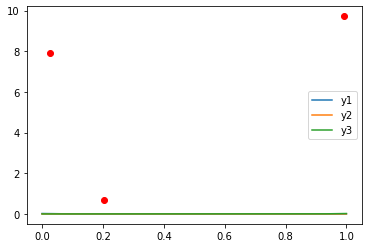

In [603]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Given parameters
mu1, sigma1 = 0, 0.04
mu2, sigma2 = 0.5, 0.2
mu3, sigma3 = 1, 0.04

# Create the x values
x_can = np.linspace(0, 1, 1000)

# Create the y values (PDFs)
y1 = norm.pdf(x_can, mu1, sigma1)
y2 = norm.pdf(x_can, mu2, sigma2)
y3 = norm.pdf(x_can, mu3, sigma3)

# Normalize the PDFs to form a valid probability density function
y1 /= y1.sum()
y2 /= y2.sum()
y3 /= y3.sum()

# Create cumulative distribution functions (CDFs)
cdf1 = np.cumsum(y1)
cdf2 = np.cumsum(y2)
cdf3 = np.cumsum(y3)

# Draw random samples from a uniform distribution
u1, u2, u3 = np.random.rand(3)

# Map the uniform samples to the distributions using the CDF
sample1 = x_can[np.searchsorted(cdf1, u1)]
sample2 = x_can[np.searchsorted(cdf2, u2)]
sample3 = x_can[np.searchsorted(cdf3, u3)]

# Display the results
print("Sampled points:")
print(f"From y1: {sample1}")
print(f"From y2: {sample2}")
print(f"From y3: {sample3}")

# Plot the distributions and the sampled points
plt.plot(x_can, y1, label='y1')
plt.plot(x_can, y2, label='y2')
plt.plot(x_can, y3, label='y3')
plt.scatter([sample1, sample2, sample3], [norm.pdf(sample1, mu1, sigma1), norm.pdf(sample2, mu2, sigma2), norm.pdf(sample3, mu3, sigma3)], color='red')
plt.legend()
plt.show()


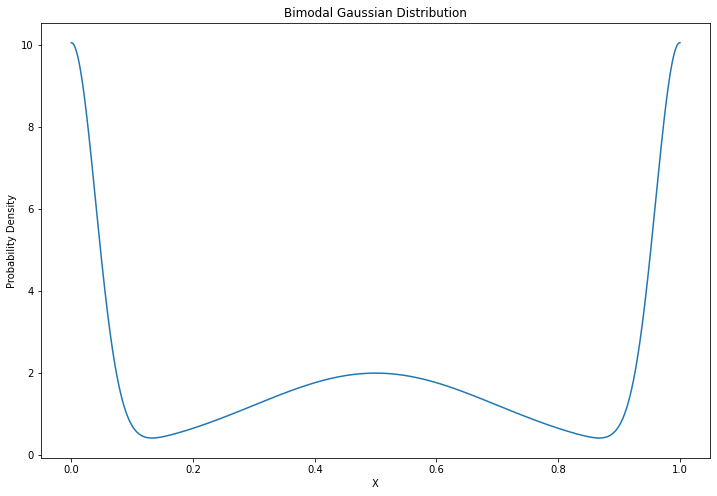

In [584]:
# Step 1: Generate a Perfect Bimodal Gaussian
mu1, sigma1 = 0, 0.04
mu2, sigma2 = 0.5, 0.2
mu3, sigma3 = 1, 0.04
x_can = np.linspace(0, 1, 1000)
y1 = norm.pdf(x, mu1, sigma1)
y2 = norm.pdf(x, mu2, sigma2)
y3 = norm.pdf(x, mu3, sigma3)
y_can = y1 + y2 + y3

plt.figure(figsize=(12, 8))

# Plot the bimodal distribution
plt.plot(x, y, label='Bimodal Gaussian Distribution')
plt.title('Bimodal Gaussian Distribution')
plt.xlabel('X')
plt.ylabel('Probability Density')

# Step 2: Divide the X-Axis into Two Halves
midpoint = len(x) // 2
x_left = x[:midpoint]
x_right = x[midpoint:]
y_left = y[:midpoint]
y_right = y[midpoint:]

In [473]:
# Step 2: Divide the X-Axis into Two Halves
midpoint = len(x) // 2
x_left = x[:midpoint]
x_right = x[midpoint:]
y_left = y[:midpoint]
y_right = y[midpoint:]

In [495]:
uni = np.linspace(0, 1, 1000)

In [591]:
def top_n_1(n, x_voter_plot, y_voter_plot, voter_dist, candidate_dist, visualize=True):
    x, y = candidate_dist
    midpoint = len(x) // 2
    x_left = x[:midpoint]
    x_right = x[midpoint:]
    y_left = y[:midpoint]
    y_right = y[midpoint:]

    random_points_left = np.random.choice(x_left, 5, replace=False)
    random_points_right = np.random.choice(x_right, 5, replace=False)

    mu1, sigma1, mu2, sigma2, mu3, sigma3 = 0, 0.1, 0.5, 0.1, 1, 0.1  # Example values for a hypothetical trimodal distribution
    y_values_left = norm.pdf(random_points_left, mu1, sigma1) + norm.pdf(random_points_left, mu2, sigma2) + norm.pdf(random_points_left, mu3, sigma3)
    y_values_right = norm.pdf(random_points_right, mu1, sigma1) + norm.pdf(random_points_right, mu2, sigma2) + norm.pdf(random_points_right, mu3, sigma3)

    points = np.concatenate((random_points_left, random_points_right))
    y_values = np.concatenate((y_values_left, y_values_right))

    top_n_indices = np.argsort(y_values)[-n:]
    top_n_points = points[top_n_indices]
    top_n_y_values = y_values[top_n_indices]

    top_left_index = np.argmax(y_values_left)
    top_right_index = np.argmax(y_values_right)
    #top_2_points = np.array([random_points_left[top_left_index], random_points_right[top_right_index]])

    top_2_indices = np.argsort(y_values)[-2:]
    top_2_points = points[top_2_indices]
    
    sampled_points = []
    while len(sampled_points) < 1000:
        new_samples = voter_dist.resample(1000).flatten()
        new_samples = new_samples[(new_samples >= 0) & (new_samples <= 1)]
        sampled_points.extend(new_samples)
    sampled_points = np.array(sampled_points[:1000])

    min_point = np.min(top_n_points)
    max_point = np.max(top_n_points)
    top_n_points_normalized = (top_n_points - min_point) / (max_point - min_point)

    ballot_counts = {}

    for point in sampled_points:
        distances = np.abs(top_n_points - point)
        sorted_indices = np.argsort(distances)
        ranking = tuple(top_n_points[sorted_indices])
        if ranking in ballot_counts:
            ballot_counts[ranking] += 1
        else:
            ballot_counts[ranking] = 1

    election = voting_rules(ballot_counts, top_n_points)
    irv_winner = election.irv()[0]
    condorcet_winner = election.condorcet()

    ballot_counts_top_2 = {}

    for point in sampled_points:
        distances = np.abs(top_2_points - point)
        sorted_indices = np.argsort(distances)
        ranking = tuple(top_2_points[sorted_indices])
        if ranking in ballot_counts_top_2:
            ballot_counts_top_2[ranking] += 1
        else:
            ballot_counts_top_2[ranking] = 1

    plurality_election = voting_rules(ballot_counts_top_2, top_2_points)
    #plurality_winner = plurality_election.plurality()

    top_2_y_values = [voter_dist.evaluate(point)[0] for point in top_2_points]
    plurality_winner = top_2_points[np.argmax(top_2_y_values)]

    if visualize:
        plt.figure(figsize=(12, 8))

        plt.subplot(2, 1, 1)
        plt.plot(x, y, label='Candidate Distribution')
        plt.scatter(random_points_left, np.zeros_like(random_points_left), color='blue', label='Random Points (Left)', zorder=5)
        plt.scatter(random_points_right, np.zeros_like(random_points_right), color='red', label='Random Points (Right)', zorder=5)
        plt.scatter(top_2_points, np.zeros_like(top_2_points), color='green', s=100, label='Top 2 Points', zorder=5)
        plt.scatter(top_n_points, np.zeros_like(top_n_points), marker='x', color='green', s=100, label='Top N Points', zorder=5)
        plt.legend()
        plt.title('Candidate Distribution with Random Points and Top N Points')
        plt.xlabel('X')
        plt.ylabel('Probability Density')

        #x_voter_plot = np.linspace(0, 1, 1000)
        #y_voter_plot = voter_dist.evaluate(x_voter_plot)

        plt.subplot(2, 1, 2)
        plt.plot(x_voter_plot, y_voter_plot, label='Voter Distribution')
        plt.scatter(sampled_points, np.zeros_like(sampled_points), color='purple', label='Sampled Points from KDE', zorder=5)
        plt.scatter(top_n_points, np.zeros_like(top_n_points), color='green', s=100, label='Top N Points', zorder=5)
        plt.scatter(irv_winner, 0, marker='o', color='yellow', s=100, label='IRV Winner', zorder=5)
        plt.scatter(plurality_winner, 0, marker='x', color='green', s=100, label='Plurality Winner', zorder=5)
        plt.scatter(condorcet_winner, 0, marker='*', color='red', s=100, label='Condorcet Winner', zorder=5)
        plt.axvline(x=np.median(sampled_points), color='red', linestyle='--', label='Median Voter')
        plt.xlabel('Value')
        plt.ylabel('Density')
        plt.title('Voter Distribution with Sampled Points and Winners')
        plt.legend()

        plt.tight_layout()
        plt.show()


    return irv_winner, plurality_winner, condorcet_winner, top_n_points

In [633]:
def top_n(n, x_voter_plot, y_voter_plot, voter_dist, candidate_dist, visualize=True):
    x_can, y_can = candidate_dist

    # Select 10 random points from the candidate distribution based on their probability
    candidate_points = np.random.choice(x_can, size=10, p=y_can/y_can.sum(), replace=False)

    #round 1
    sampled_points_primary = []
    while len(sampled_points_primary) < 1000:
        new_samples = voter_dist.resample(1000).flatten()
        new_samples = new_samples[(new_samples >= 0) & (new_samples <= 1)]
        sampled_points_primary.extend(new_samples)
    sampled_points_primary = np.array(sampled_points_primary[:1000])   

    counts = np.zeros(len(candidate_points))
    for point in sampled_points_primary:
        closest_candidate_index = np.argmin(np.abs(candidate_points - point))
        counts[closest_candidate_index] += 1
    
    # Sort candidate points by their counts and select the top n
    top_n_indices = np.argsort(counts)[::-1][:n]
    top_n_points = candidate_points[top_n_indices]

    #round 2
    sampled_points = []
    while len(sampled_points) < 1000:
        new_samples = voter_dist.resample(1000).flatten()
        new_samples = new_samples[(new_samples >= 0) & (new_samples <= 1)]
        sampled_points.extend(new_samples)
    sampled_points = np.array(sampled_points[:1000])

    min_point = np.min(top_n_points)
    max_point = np.max(top_n_points)
    top_n_points_normalized = (top_n_points - min_point) / (max_point - min_point)

    ballot_counts = {}

    for point in sampled_points:
        distances = np.abs(top_n_points - point)
        sorted_indices = np.argsort(distances)
        ranking = tuple(top_n_points[sorted_indices])
        if ranking in ballot_counts:
            ballot_counts[ranking] += 1
        else:
            ballot_counts[ranking] = 1

    election = voting_rules(ballot_counts, top_n_points)
    irv_winner = election.irv()[0]
    condorcet_winner = election.condorcet()

    #plurality_election = voting_rules(ballot_counts_top_2, top_2_points)
    plurality_winner = election.plurality()


    if visualize:
        plt.figure(figsize=(12, 8))

        plt.subplot(2, 1, 1)
        plt.plot(x, y, label='Candidate Distribution')
        plt.scatter(candidate_points, np.zeros_like(candidate_points), color='blue', label='Random Candidates (10)', zorder=5)
        #plt.scatter(random_points_left, np.zeros_like(random_points_left), color='blue', label='Random Points (Left)', zorder=5)
        #plt.scatter(random_points_right, np.zeros_like(random_points_right), color='red', label='Random Points (Right)', zorder=5)
        #plt.scatter(top_2_points, np.zeros_like(top_2_points), color='green', s=100, label='Top 2 Points', zorder=5)
        plt.scatter(top_n_points, np.zeros_like(top_n_points), marker='x', color='green', s=100, label='Top N Points', zorder=5)
        plt.legend()
        plt.title('Candidate Distribution with Random Points and Top N Points')
        plt.xlabel('X')
        plt.ylabel('Probability Density')

        #x_voter_plot = np.linspace(0, 1, 1000)
        #y_voter_plot = voter_dist.evaluate(x_voter_plot)

        plt.subplot(2, 1, 2)
        plt.plot(x_voter_plot, y_voter_plot, label='Voter Distribution')
        #plt.scatter(sampled_points, np.zeros_like(sampled_points), color='purple', label='Sampled Points from KDE', zorder=5)
        plt.scatter(top_n_points, np.zeros_like(top_n_points), color='green', s=100, label='Top N Points', zorder=5)
        plt.scatter(irv_winner, 0, marker='o', color='yellow', s=100, label='IRV Winner', zorder=5)
        plt.scatter(plurality_winner, 0, marker='x', color='green', s=100, label='Plurality Winner', zorder=5)
        plt.scatter(condorcet_winner, 0, marker='*', color='red', s=100, label='Condorcet Winner', zorder=5)
        plt.axvline(x=np.median(sampled_points), color='red', linestyle='--', label='Median Voter')
        plt.xlabel('Value')
        plt.ylabel('Density')
        plt.title('Voter Distribution with Sampled Points and Winners')
        plt.legend()

        plt.tight_layout()
        plt.show()


    return irv_winner, plurality_winner, condorcet_winner, top_n_points

[0.04904905 0.46346346 0.98398398]


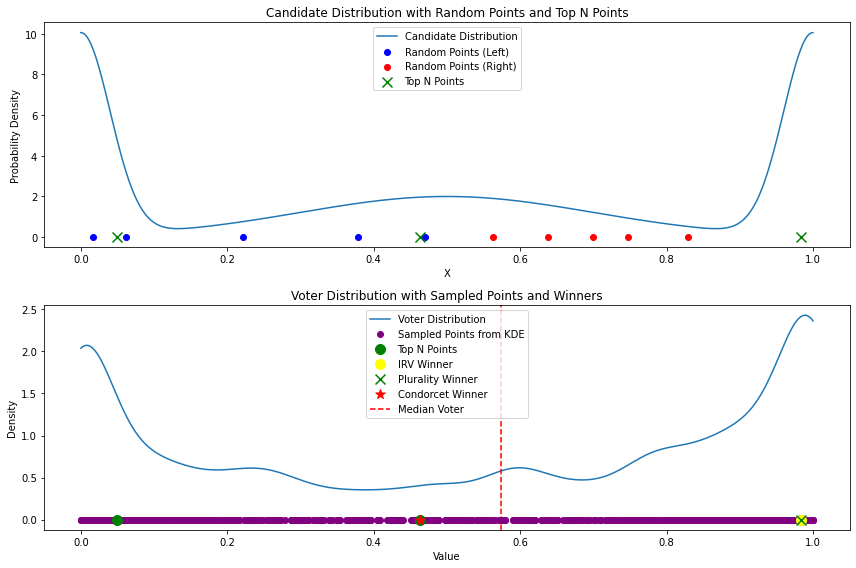

(0.983983983983984,
 0.983983983983984,
 0.46346346346346345,
 array([0.04904905, 0.46346346, 0.98398398]))

In [620]:

# Given parameters
mu1, sigma1 = 0, 0.04
mu2, sigma2 = 0.5, 0.2
mu3, sigma3 = 1, 0.04

# Create the x values
x_can = np.linspace(0, 1, 1000)

# Create the y values (PDFs)
y1 = norm.pdf(x_can, mu1, sigma1)
y2 = norm.pdf(x_can, mu2, sigma2)
y3 = norm.pdf(x_can, mu3, sigma3)
y_can = y1 + y2 + y3

# Normalize the PDFs to form a valid probability density function
y1 /= y1.sum()
y2 /= y2.sum()
y3 /= y3.sum()

# Create cumulative distribution functions (CDFs)
cdf1 = np.cumsum(y1)
cdf2 = np.cumsum(y2)
cdf3 = np.cumsum(y3)

# Draw random samples from a uniform distribution
u1, u2, u3 = np.random.rand(3)

# Map the uniform samples to the distributions using the CDF
sample1 = x_can[np.searchsorted(cdf1, u1)]
sample2 = x_can[np.searchsorted(cdf2, u2)]
sample3 = x_can[np.searchsorted(cdf3, u3)]
top_given_n(x_yes, kde_values_yes, kde_yes, [sample1, sample2, sample3])

In [704]:
def top_given_n(x_voter_plot, y_voter_plot, voter_dist, top_n_points, visualize=True):
    #top 3 candiates are given
    
    points = np.concatenate((random_points_left, random_points_right))
    y_values = np.concatenate((y_values_left, y_values_right))

    #top_n_indices = np.argsort(y_values)[-n:]
    #top_n_points = points[top_n_indices]
    top_n_y_values = y_values[top_n_indices]

    top_left_index = np.argmax(y_values_left)
    top_right_index = np.argmax(y_values_right)
    #top_2_points = np.array([random_points_left[top_left_index], random_points_right[top_right_index]])

    top_2_indices = np.argsort(y_values)[-2:]
    top_2_points = points[top_2_indices]
    
    sampled_points = []
    while len(sampled_points) < 1000:
        new_samples = voter_dist.resample(1000).flatten()
        new_samples = new_samples[(new_samples >= 0) & (new_samples <= 1)]
        sampled_points.extend(new_samples)
    sampled_points = np.array(sampled_points[:1000])

    min_point = np.min(top_n_points)
    max_point = np.max(top_n_points)
    top_n_points_normalized = (top_n_points - min_point) / (max_point - min_point)

    ballot_counts = {}
    top_n_points = np.array(top_n_points)
    
    for point in sampled_points:
        distances = np.abs(top_n_points - point)
        sorted_indices = np.argsort(distances)
        ranking = tuple(top_n_points[sorted_indices])
        if ranking in ballot_counts:
            ballot_counts[ranking] += 1
        else:
            ballot_counts[ranking] = 1

    election = voting_rules(ballot_counts, top_n_points)
    irv_winner = election.irv()[0]
    condorcet_winner = election.condorcet()

    ballot_counts_top_2 = {}

    """for point in sampled_points:
        distances = np.abs(top_2_points - point)
        sorted_indices = np.argsort(distances)
        ranking = tuple(top_2_points[sorted_indices])
        if ranking in ballot_counts_top_2:
            ballot_counts_top_2[ranking] += 1
        else:
            ballot_counts_top_2[ranking] = 1"""

    plurality_election = voting_rules(ballot_counts_top_2, top_2_points)
    #plurality_winner = plurality_election.plurality()

    top_2_y_values = [voter_dist.evaluate(point)[0] for point in top_2_points]
    plurality_winner = election.plurality()
    
    if visualize:
        plt.figure(figsize=(12, 8))

        plt.subplot(2, 1, 1)
        plt.plot(x, y, label='Candidate Distribution')
        plt.scatter(random_points_left, np.zeros_like(random_points_left), color='blue', label='Random Points (Left)', zorder=5)
        plt.scatter(random_points_right, np.zeros_like(random_points_right), color='red', label='Random Points (Right)', zorder=5)
        #plt.scatter(top_2_points, np.zeros_like(top_2_points), color='green', s=100, label='Top 2 Points', zorder=5)
        plt.scatter(top_n_points, np.zeros_like(top_n_points), marker='x', color='green', s=100, label='Top N Points', zorder=5)
        plt.legend()
        plt.title('Candidate Distribution with Random Points and Top N Points')
        plt.xlabel('X')
        plt.ylabel('Probability Density')

        #x_voter_plot = np.linspace(0, 1, 1000)
        #y_voter_plot = voter_dist.evaluate(x_voter_plot)

        plt.subplot(2, 1, 2)
        plt.plot(x_voter_plot, y_voter_plot, label='Voter Distribution')
        plt.scatter(sampled_points, np.zeros_like(sampled_points), color='purple', label='Sampled Points from KDE', zorder=5)
        plt.scatter(top_n_points, np.zeros_like(top_n_points), color='green', s=100, label='Top N Points', zorder=5)
        plt.scatter(irv_winner, 0, marker='o', color='yellow', s=100, label='IRV Winner', zorder=5)
        plt.scatter(plurality_winner, 0, marker='x', color='green', s=100, label='Plurality Winner', zorder=5)
        plt.scatter(condorcet_winner, 0, marker='*', color='red', s=100, label='Condorcet Winner', zorder=5)
        plt.axvline(x=np.median(sampled_points), color='red', linestyle='--', label='Median Voter')
        plt.xlabel('Value')
        plt.ylabel('Density')
        plt.title('Voter Distribution with Sampled Points and Winners')
        plt.legend()

        plt.tight_layout()
        plt.show()


    return irv_winner, plurality_winner, condorcet_winner, top_n_points

In [504]:
mu1, sigma1 = 0, 0.1
mu2, sigma2 = 1, 0.1
x_voter = np.linspace(0, 1, 1000)
y1_voter = norm.pdf(x_voter, mu1, sigma1)
y2_voter = norm.pdf(x_voter, mu2, sigma2)
y_voter = y1_voter + y2_voter
voter_data = np.concatenate([np.random.normal(mu1, sigma1, 500), np.random.normal(mu2, sigma2, 500)])
voter_data = voter_data[(voter_data >= 0) & (voter_data <= 1)]
voter_kde = gaussian_kde(voter_data)

In [505]:
x_candidate = np.linspace(0, 1, 1000)
y_candidate = np.ones_like(x_candidate) / len(x_candidate)

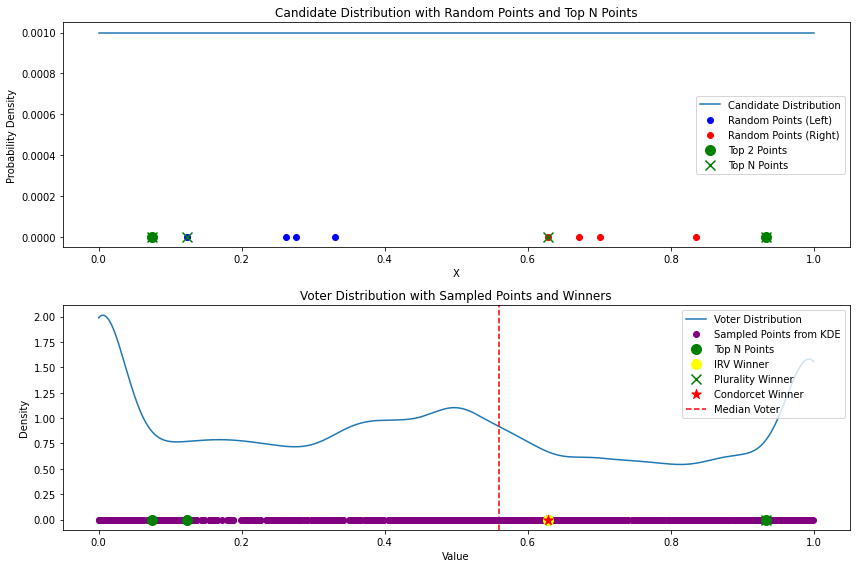

(0.6286286286286287,
 0.9329329329329329,
 0.6286286286286287,
 array([0.62862863, 0.12312312, 0.07507508, 0.93293293]))

In [587]:
mirrored_yes = 1 - np.array(level_data['LOCAL'])
mirrored_kde = gaussian_kde(mirrored_yes, bw_method=0.1)
x_yes_reversed = x[::-1]
kde_values_yes_reversed = kde_values[::-1]
top_n(4, x_yes_reversed, kde_values_yes_reversed, mirrored_kde, (x_candidate, y_candidate))


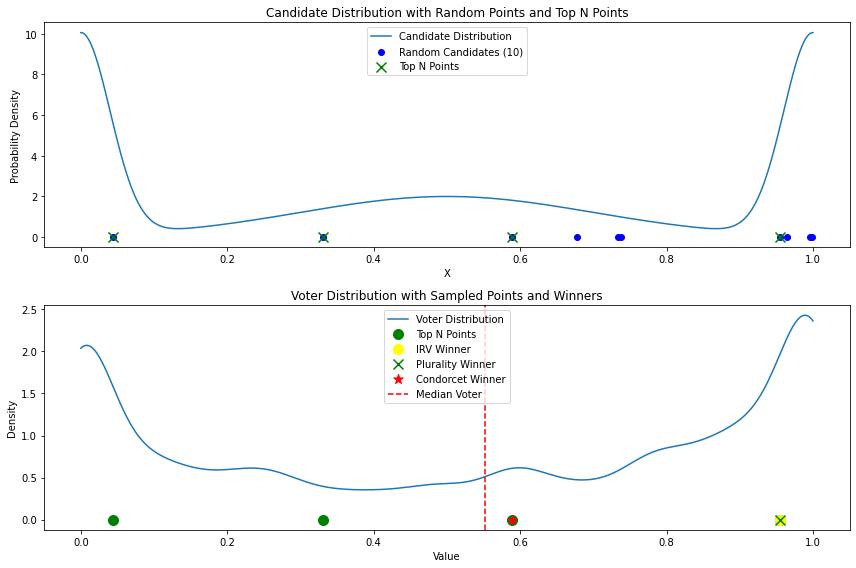

(0.954954954954955,
 0.954954954954955,
 0.5885885885885885,
 array([0.04404404, 0.95495495, 0.33133133, 0.58858859]))

In [644]:
# Given parameters
mu1, sigma1 = 0, 0.04
mu2, sigma2 = 0.5, 0.2
mu3, sigma3 = 1, 0.04

# Create the x values
x_can = np.linspace(0, 1, 1000)

# Create the y values (PDFs)
y1 = norm.pdf(x_can, mu1, sigma1)
y2 = norm.pdf(x_can, mu2, sigma2)
y3 = norm.pdf(x_can, mu3, sigma3)
y_can = y1 + y2 + y3
top_n(4, x_yes, kde_values_yes, kde_yes, (x_can, y_can), visualize=True)

In [672]:
def generate_and_group_permutations(items, choices):
    n = len(items)
    grouped_permutations = defaultdict(list)
    
    for i in range(1, choices + 1):
        for perm in permutations(items, i):
            grouped_permutations[perm[0]].append(perm)
    
    return grouped_permutations

In [673]:
perms = generate_and_group_permutations([1, 2, 3, 4], 4)
print(perms)

for point in perms:
    perms[point] = [b for b in perms[point] if is_consistent(b, {1: 1, 2: 2, 3: 3, 4: 4})==False]
print(perms)


defaultdict(<class 'list'>, {1: [(1,), (1, 2), (1, 3), (1, 4), (1, 2, 3), (1, 2, 4), (1, 3, 2), (1, 3, 4), (1, 4, 2), (1, 4, 3), (1, 2, 3, 4), (1, 2, 4, 3), (1, 3, 2, 4), (1, 3, 4, 2), (1, 4, 2, 3), (1, 4, 3, 2)], 2: [(2,), (2, 1), (2, 3), (2, 4), (2, 1, 3), (2, 1, 4), (2, 3, 1), (2, 3, 4), (2, 4, 1), (2, 4, 3), (2, 1, 3, 4), (2, 1, 4, 3), (2, 3, 1, 4), (2, 3, 4, 1), (2, 4, 1, 3), (2, 4, 3, 1)], 3: [(3,), (3, 1), (3, 2), (3, 4), (3, 1, 2), (3, 1, 4), (3, 2, 1), (3, 2, 4), (3, 4, 1), (3, 4, 2), (3, 1, 2, 4), (3, 1, 4, 2), (3, 2, 1, 4), (3, 2, 4, 1), (3, 4, 1, 2), (3, 4, 2, 1)], 4: [(4,), (4, 1), (4, 2), (4, 3), (4, 1, 2), (4, 1, 3), (4, 2, 1), (4, 2, 3), (4, 3, 1), (4, 3, 2), (4, 1, 2, 3), (4, 1, 3, 2), (4, 2, 1, 3), (4, 2, 3, 1), (4, 3, 1, 2), (4, 3, 2, 1)]})
defaultdict(<class 'list'>, {1: [(1, 3, 2), (1, 4, 2), (1, 4, 3), (1, 2, 4, 3), (1, 3, 2, 4), (1, 3, 4, 2), (1, 4, 2, 3), (1, 4, 3, 2)], 2: [(2, 4, 3), (2, 1, 4, 3), (2, 4, 1, 3), (2, 4, 3, 1)], 3: [(3, 1, 2), (3, 1, 2, 4), (3, 1,

In [734]:
def top_n_gamma(n, x_voter_plot, y_voter_plot, voter_dist, candidate_dist, visualize=True):
    # This function is the same as top_n, it just integrates gamma

    x_can, y_can = candidate_dist

    # Select 10 random points from the candidate distribution based on their probability
    candidate_points = np.random.choice(x_can, size=10, p=y_can/y_can.sum(), replace=False)


    df = pd.read_csv("median_voter_analysis.csv")
    
    # Filter the DataFrame for rows where #candidates equals n
    filtered_df = df[df['#candidates'] == n]
    
    # Extract the gamma values and convert to a NumPy array
    gamma_values = filtered_df['gamma'].to_numpy()
    # Draw a random number from the gamma values distribution
    random_gamma = np.random.choice(gamma_values)
  
    # Multiply by 1000 and round to the nearest integer
    consistent_voters = round(random_gamma * 1000)
    
    #round 1
    sampled_points_primary = []
    while len(sampled_points_primary) < 1000:
        new_samples = voter_dist.resample(1000).flatten()
        new_samples = new_samples[(new_samples >= 0) & (new_samples <= 1)]
        sampled_points_primary.extend(new_samples)
    sampled_points_primary = np.array(sampled_points_primary[:1000])   

    counts = np.zeros(len(candidate_points))
    for point in sampled_points_primary:
        closest_candidate_index = np.argmin(np.abs(candidate_points - point))
        counts[closest_candidate_index] += 1
    
    # Sort candidate points by their counts and select the top n
    top_n_indices = np.argsort(counts)[::-1][:n]
    top_n_points = candidate_points[top_n_indices]
    normalized_distances = {element: element for element in top_n_points}


    #round 2
    sampled_points = []
    while len(sampled_points) < consistent_voters:
        new_samples = voter_dist.resample(consistent_voters).flatten()
        new_samples = new_samples[(new_samples >= 0) & (new_samples <= 1)]
        sampled_points.extend(new_samples)
    sampled_points = np.array(sampled_points[:consistent_voters])

    min_point = np.min(top_n_points)
    max_point = np.max(top_n_points)
    top_n_points_normalized = (top_n_points - min_point) / (max_point - min_point)

    ballot_counts = {}

    for point in sampled_points:
        distances = np.abs(top_n_points - point)
        sorted_indices = np.argsort(distances)
        ranking = tuple(top_n_points[sorted_indices])
        if ranking in ballot_counts:
            ballot_counts[ranking] += 1
        else:
            ballot_counts[ranking] = 1

    perms = generate_and_group_permutations(top_n_points, n)

    for point in perms:
        perms[point] = [b for b in perms[point] if is_consistent(b, normalized_distances)==False]

    inconsistent_voters = 1000 - consistent_voters
    inconsistent_ballots_list = random.choices(perms, k=inconsistent_voters)

    sampled_points_inconsistet = []
    while len(sampled_points_inconsistet) < inconsistent_voters:
        new_samples = voter_dist.resample(inconsistent_voters).flatten()
        new_samples = new_samples[(new_samples >= 0) & (new_samples <= 1)]
        sampled_points_inconsistet.extend(new_samples)
    sampled_points_inconsistet = np.array(sampled_points_inconsistet[:inconsistent_voters])

    for point in sampled_points_inconsistet:
        distances = np.abs(top_n_points - point)
        min_index = np.argmin(distances)
        closest_point = top_n_points[min_index]
        ranking = random.choices(perms[closest_point], k=1)[0]
        
        if ranking not in ballot_counts:
            ballot_counts[ranking] = 0
        ballot_counts[ranking] += 1


    election = voting_rules(ballot_counts, top_n_points)
    irv_winner = election.irv()[0]
    condorcet_winner = election.condorcet()

    #plurality_election = voting_rules(ballot_counts_top_2, top_2_points)
    plurality_winner = election.plurality()
    first_place_support = election.get_first_place()

    if condorcet_winner == -1:
        first_place_support[condorcet_winner] = -1

    if visualize:
        plt.figure(figsize=(12, 8))

        #plt.subplot(2, 1, 1)
        plt.plot(x, y, label='Candidate Distribution')
        plt.scatter(candidate_points, np.zeros_like(candidate_points), color='blue', label='Random Candidates (10)', zorder=5)
        #plt.scatter(random_points_left, np.zeros_like(random_points_left), color='blue', label='Random Points (Left)', zorder=5)
        #plt.scatter(random_points_right, np.zeros_like(random_points_right), color='red', label='Random Points (Right)', zorder=5)
        #plt.scatter(top_2_points, np.zeros_like(top_2_points), color='green', s=100, label='Top 2 Points', zorder=5)
        plt.scatter(top_n_points, np.zeros_like(top_n_points), marker='x', color='green', s=100, label='Top N Points', zorder=5)
        plt.legend()
        plt.title('Candidate Distribution with Random Points and Top N Points')
        plt.xlabel('X')
        plt.ylabel('Probability Density')
        plt.show()
        plt.close()
        #x_voter_plot = np.linspace(0, 1, 1000)
        #y_voter_plot = voter_dist.evaluate(x_voter_plot)

        #plt.subplot(2, 1, 2)
        plt.figure(figsize=(12, 8))
        plt.plot(x_voter_plot, y_voter_plot, label='Voter Distribution')
        #plt.scatter(sampled_points, np.zeros_like(sampled_points), color='purple', label='Sampled Points from KDE', zorder=5)
        #plt.scatter(top_n_points, np.zeros_like(top_n_points), color='green', s=100, label='Top N Points', zorder=5)
        #plt.scatter(irv_winner, 0, marker='o', color='yellow', s=100, label='IRV Winner', zorder=5)
        #plt.scatter(plurality_winner, 0, marker='x', color='green', s=100, label='Plurality Winner', zorder=5)
        #plt.scatter(condorcet_winner, 0, marker='*', color='red', s=100, label='Condorcet Winner', zorder=5)
        plt.axvline(x=np.median(sampled_points), color='red', linestyle='--', label='Median Voter')
        plt.xlabel('Value')
        plt.ylabel('Density')
        plt.title('Voter Distribution with Sampled Points and Winners')
        plt.legend()

        plt.tight_layout()
        plt.show()


    return irv_winner, plurality_winner, condorcet_winner, top_n_points, random_gamma, first_place_support[condorcet_winner], first_place_support[irv_winner], first_place_support[plurality_winner]

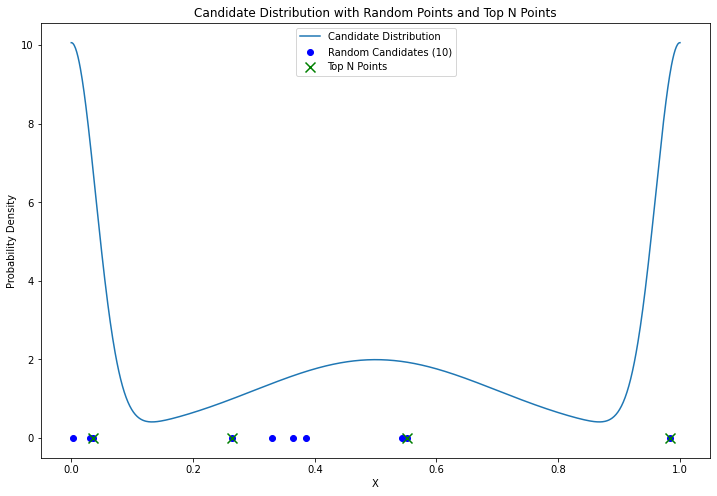

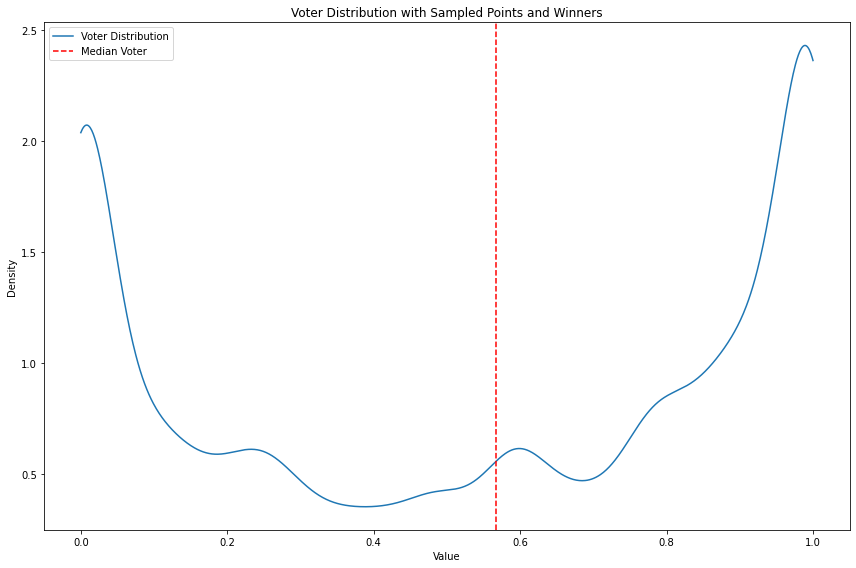

(0.9829829829829829,
 0.9829829829829829,
 0.5515515515515516,
 array([0.98298298, 0.55155155, 0.03603604, 0.26426426]),
 0.84234171,
 238,
 350,
 350)

In [722]:
# Given parameters
mu1, sigma1 = 0, 0.04
mu2, sigma2 = 0.5, 0.2
mu3, sigma3 = 1, 0.04

# Create the x values
x_can = np.linspace(0, 1, 1000)

# Create the y values (PDFs)
y1 = norm.pdf(x_can, mu1, sigma1)
y2 = norm.pdf(x_can, mu2, sigma2)
y3 = norm.pdf(x_can, mu3, sigma3)
y_can = y1 + y2 + y3
top_n_gamma(4, x_yes, kde_values_yes, kde_yes, (x_can, y_can), visualize=True)

In [659]:
num_runs = 1000
irv_winners = []
plurality_winners = []
condorcet_winners = []
top_n_points_list = []

for i in range(num_runs):
    # Draw random samples from a uniform distribution
    u1, u2, u3 = np.random.rand(3)

    # Map the uniform samples to the distributions using the CDF
    sample1 = x_can[np.searchsorted(cdf1, u1)]
    sample2 = x_can[np.searchsorted(cdf2, u2)]
    sample3 = x_can[np.searchsorted(cdf3, u3)]
    if i % 2 == 0:
        irv_winner, plurality_winner, condorcet_winner, top_n_points = top_given_n(x, kde_values, kde, [sample1, sample2, sample3], visualize=False)
        #irv_winner, plurality_winner, condorcet_winner, top_n_points = top_n(4, x, kde_values, kde, (x_can, y_can), visualize=False)
    else:
        mirrored_yes = 1 - np.array(level_data['LOCAL'])
        mirrored_kde = gaussian_kde(mirrored_yes, bw_method=0.1)
        x_yes_reversed = x[::-1]
        kde_values_yes_reversed = kde_values[::-1]
        irv_winner, plurality_winner, condorcet_winner, top_n_points = top_given_n(x_yes_reversed, kde_values_yes_reversed, mirrored_kde, [sample1, sample2, sample3], visualize=False)
    irv_winners.append(irv_winner)
    plurality_winners.append(plurality_winner)
    if condorcet_winner != -1:
        condorcet_winners.append(condorcet_winner)
    top_n_points_list.extend(top_n_points)



KeyboardInterrupt: 

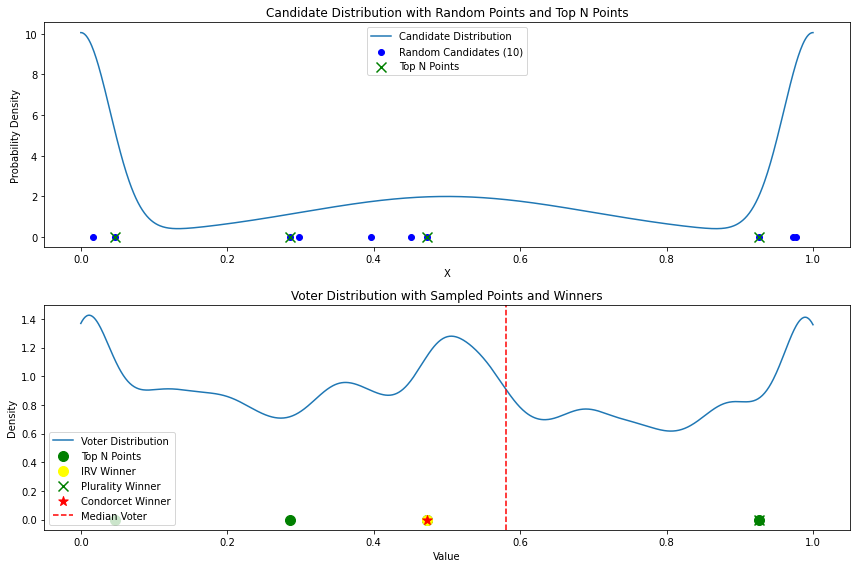

In [698]:
mirrored_no = 1 - np.array(level_data['LOCAL'])
mirrored_kde = gaussian_kde(mirrored_no, bw_method=0.1)
x_no_reversed = x_no[::-1]
kde_values_no_reversed = kde_values_no[::-1]
irv_winner, plurality_winner, condorcet_winner, top_n_points, gamma = top_n_gamma(4, x_no_reversed, kde_values_no_reversed, mirrored_kde, (x, y), visualize=True)

In [699]:
num_runs = 1000
irv_winners = []
plurality_winners = []
condorcet_winners = []
top_n_points_list = []
gamma_values = []

for i in range(num_runs):
    if i % 2 == 0:
        irv_winner, plurality_winner, condorcet_winner, top_n_points, gamma = top_n_gamma(4, x_no, kde_values_no, kde_no, (x_can, y_can), visualize=False)
    else:
        mirrored_no = 1 - np.array(level_data['LOCAL'])
        mirrored_kde = gaussian_kde(mirrored_no, bw_method=0.1)
        x_no_reversed = x_no[::-1]
        kde_values_no_reversed = kde_values_no[::-1]
        irv_winner, plurality_winner, condorcet_winner, top_n_points, gamma = top_n_gamma(4, x_no_reversed, kde_values_no_reversed, mirrored_kde, (x, y), visualize=False)
    irv_winners.append(irv_winner)
    plurality_winners.append(plurality_winner)
    gamma_values.append(gamma)
    if condorcet_winner != -1:
        condorcet_winners.append(condorcet_winner)
    top_n_points_list.extend(top_n_points)

In [735]:
num_runs = 1000
irv_winners = []
plurality_winners = []
condorcet_winners = []
top_n_points_list = []
gamma_values = []
condorcet_support = []
irv_support = []
plurality_support = []


for i in range(num_runs):
    if i % 2 == 0:
        irv_winner, plurality_winner, condorcet_winner, top_n_points, gamma, condorcet, irv, plurality = top_n_gamma(4, x_no, kde_values_no, kde_no, (x_can, y_can), visualize=False)
    else:
        mirrored_no = 1 - np.array(level_data['LOCAL'])
        mirrored_kde = gaussian_kde(mirrored_no, bw_method=0.1)
        x_no_reversed = x_no[::-1]
        kde_values_no_reversed = kde_values_no[::-1]
        irv_winner, plurality_winner, condorcet_winner, top_n_points, gamma, condorcet, irv, plurality = top_n_gamma(4, x_no_reversed, kde_values_no_reversed, mirrored_kde, (x, y), visualize=False)
    irv_winners.append(irv_winner)
    plurality_winners.append(plurality_winner)
    gamma_values.append(gamma)
    condorcet_support.append(condorcet)
    irv_support.append(irv)
    plurality_support.append(plurality)
    if condorcet_winner != -1:
        condorcet_winners.append(condorcet_winner)
    top_n_points_list.extend(top_n_points)


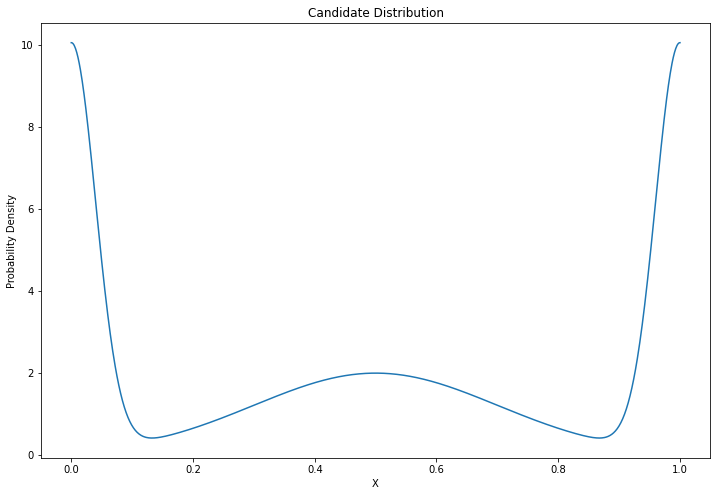

In [667]:
plt.figure(figsize=(12, 8))
plt.plot(x_can, y_can, label='Candidate Distribution')
plt.title('Candidate Distribution')
plt.xlabel('X')
plt.ylabel('Probability Density')
plt.show()

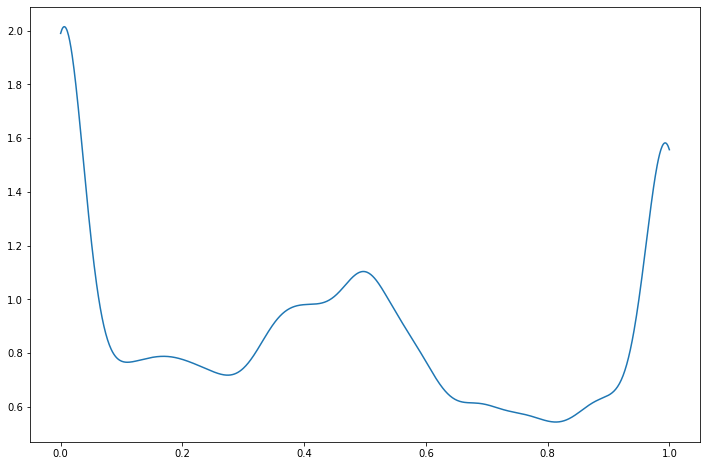

In [630]:
plt.figure(figsize=(12, 8))
plt.plot(x, kde_values, label='Voter Distribution')
plt.show()

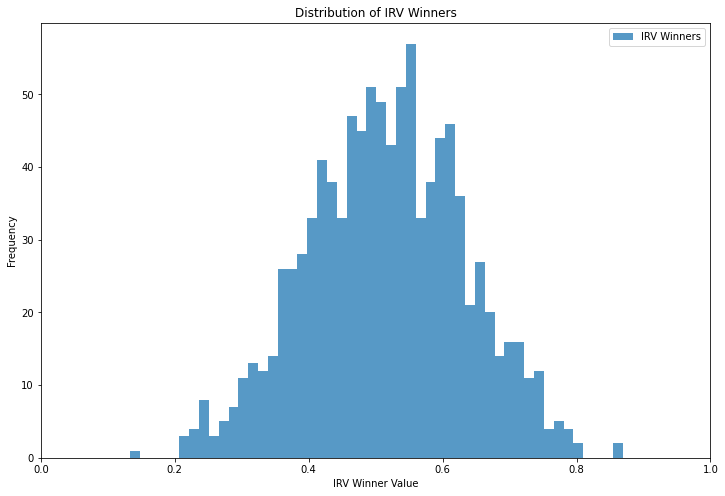

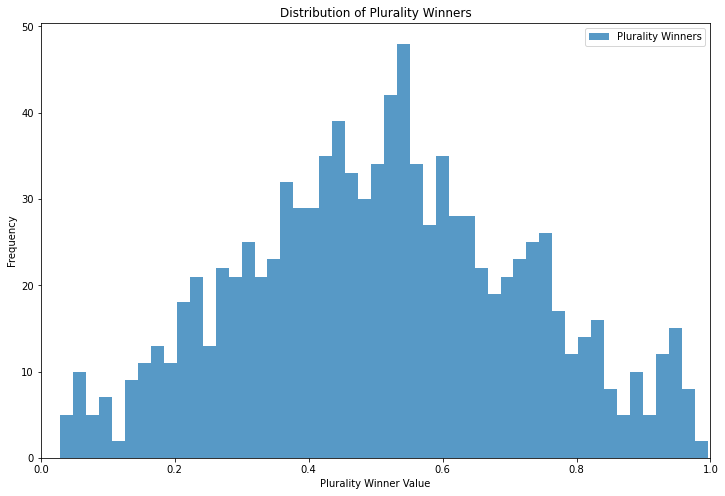

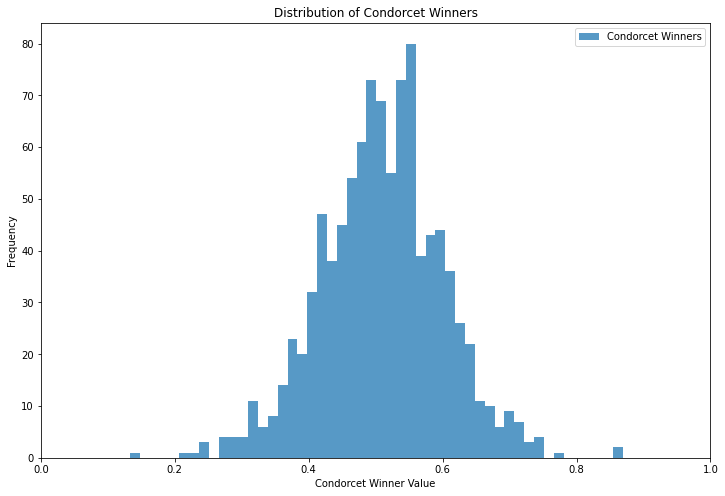

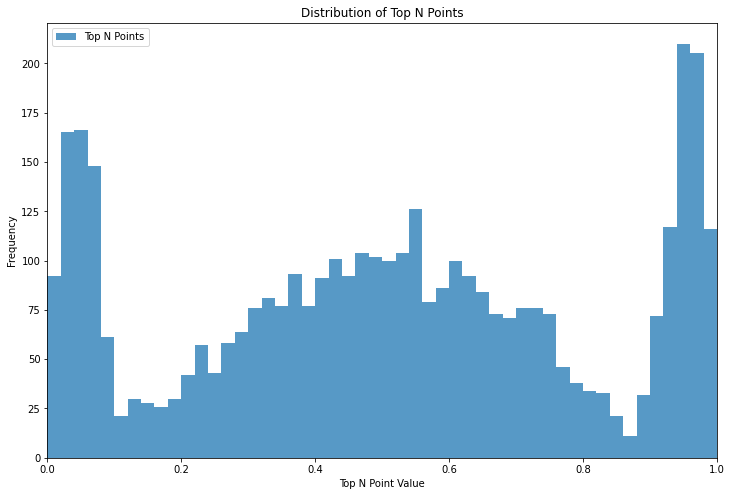

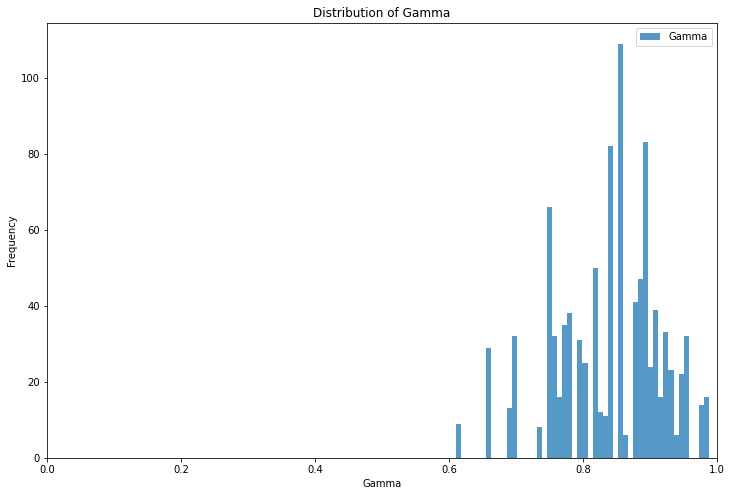

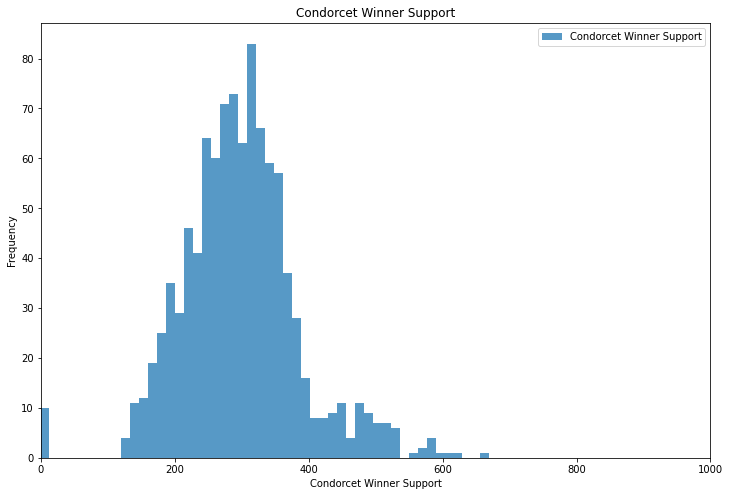

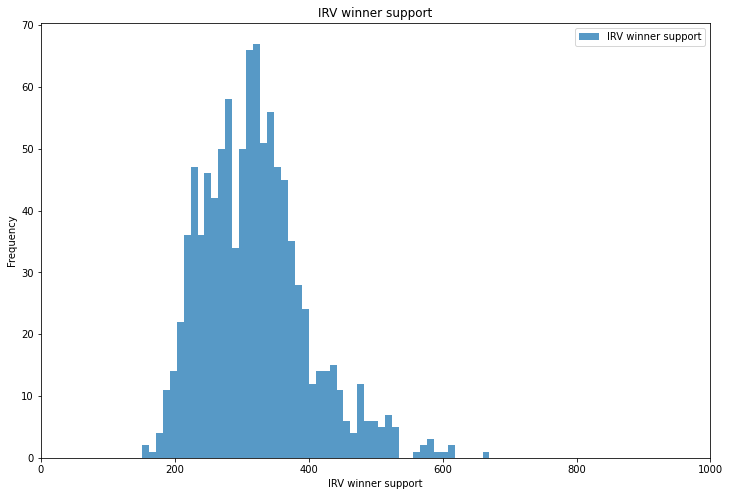

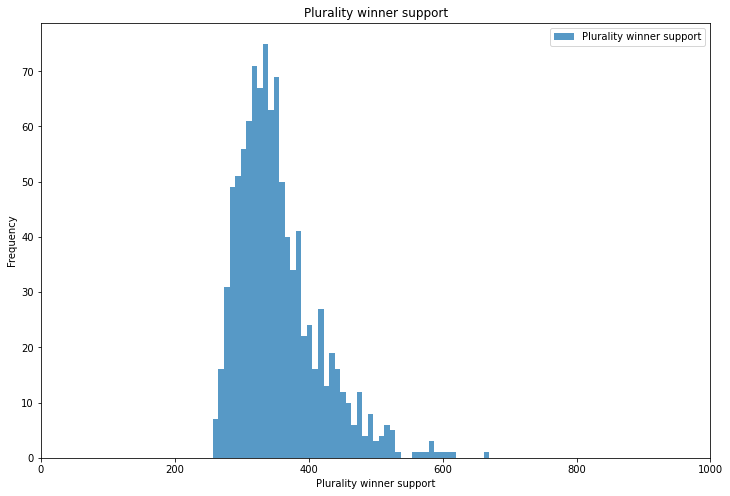

In [736]:
# Plot IRV winners
plt.figure(figsize=(12, 8))
plt.hist(irv_winners, bins=50, alpha=0.75, label='IRV Winners')
plt.xlabel('IRV Winner Value')
plt.ylabel('Frequency')
plt.xlim(0, 1) 
plt.title('Distribution of IRV Winners')
plt.legend()
plt.show()

# Plot Plurality winners
plt.figure(figsize=(12, 8))
plt.hist(plurality_winners, bins=50, alpha=0.75, label='Plurality Winners')
plt.xlabel('Plurality Winner Value')
plt.ylabel('Frequency')
plt.xlim(0, 1) 
plt.title('Distribution of Plurality Winners')
plt.legend()
plt.show()

# Plot Condorcet winners
plt.figure(figsize=(12, 8))
plt.hist(condorcet_winners, bins=50, alpha=0.75, label='Condorcet Winners')
plt.xlabel('Condorcet Winner Value')
plt.ylabel('Frequency')
plt.xlim(0, 1) 
plt.title('Distribution of Condorcet Winners')
plt.legend()
plt.show()

# Plot distribution of top 2 points
plt.figure(figsize=(12, 8))
plt.hist(top_n_points_list, bins=50, alpha=0.75, label='Top N Points')
plt.xlabel('Top N Point Value')
plt.ylabel('Frequency')
plt.xlim(0, 1) 
plt.title('Distribution of Top N Points')
plt.legend()
plt.show()

# Plot distribution of gamma
plt.figure(figsize=(12, 8))
plt.hist(gamma_values, bins=50, alpha=0.75, label='Gamma')
plt.xlabel('Gamma')
plt.ylabel('Frequency')
plt.xlim(0, 1) 
plt.title('Distribution of Gamma')
plt.legend()
plt.show()

# Plot distribution of c-s
plt.figure(figsize=(12, 8))
plt.hist(condorcet_support, bins=50, alpha=0.75, label='Condorcet Winner Support')
plt.xlabel('Condorcet Winner Support')
plt.ylabel('Frequency')
plt.xlim(0, 1000) 
plt.title('Condorcet Winner Support')
plt.legend()
plt.show()

# Plot distribution of irv-s
plt.figure(figsize=(12, 8))
plt.hist(irv_support, bins=50, alpha=0.75, label='IRV winner support')
plt.xlabel('IRV winner support')
plt.ylabel('Frequency')
plt.xlim(0, 1000) 
plt.title('IRV winner support')
plt.legend()
plt.show()

# Plot distribution of p-s
plt.figure(figsize=(12, 8))
plt.hist(plurality_support, bins=50, alpha=0.75, label='Plurality winner support')
plt.xlabel('Plurality winner support')
plt.ylabel('Frequency')
plt.xlim(0, 1000) 
plt.title('Plurality winner support')
plt.legend()
plt.show()


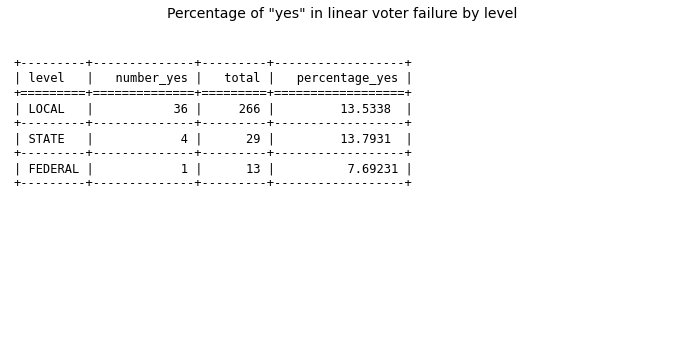

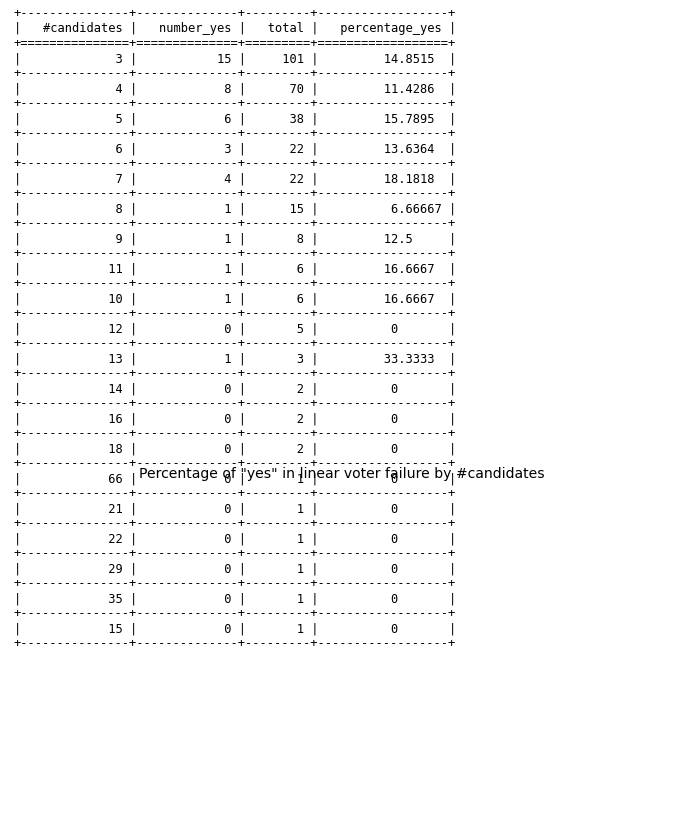

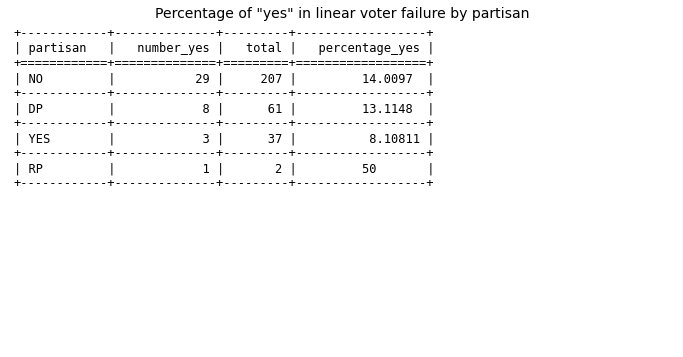

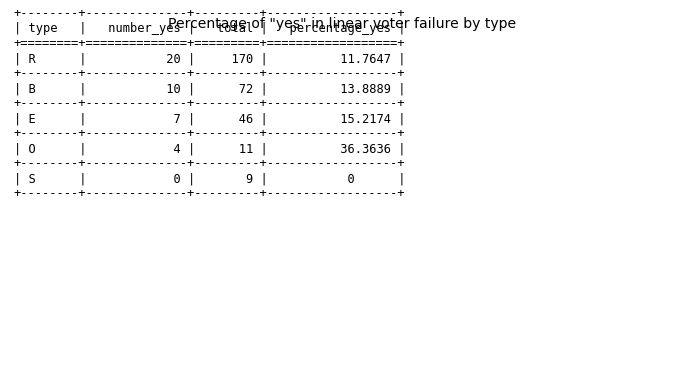

In [ ]:
import pandas as pd
from tabulate import tabulate
import matplotlib.pyplot as plt
import io

# Load the CSV file
df = pd.read_csv('median_voter_analysis.csv')
df = df[df['#candidates'] > 2]

# Define a function to calculate and plot percentages with totals and number of 'yes'
def plot_percentage_table(df, column, output_file):
    # Calculate the counts and percentages
    counts = df[df['linear voters failure'] == 'yes'][column].value_counts()
    total_counts = df[column].value_counts()
    
    # Align indices and fill missing values with 0
    counts = counts.reindex(total_counts.index, fill_value=0)
    percentage_yes = (counts / total_counts) * 100

    # Create the DataFrame
    data = pd.DataFrame({
        column: counts.index,
        'number_yes': counts.values,
        'total': total_counts.values,
        'percentage_yes': percentage_yes.values
    }).fillna(0)  # Fill NaN with 0 for categories with no 'yes'

    # Create a table using tabulate
    table_str = tabulate(data, headers='keys', tablefmt='grid', showindex=False)

    # Save the table as an image
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.axis('off')
    plt.text(0.01, 0.5, table_str, {'family': 'monospace'}, fontsize=12)
    plt.title(f'Percentage of "yes" in linear voter failure by {column}', fontsize=14)
    #plt.savefig(output_file, bbox_inches='tight', pad_inches=0.1)
    plt.show()
    plt.close()

# Plot and save the tables for 'level', '#candidates', 'partisan', and 'type'
plot_percentage_table(df, 'level', 'level_percentage_table.png')
plot_percentage_table(df, '#candidates', 'candidates_percentage_table.png')
plot_percentage_table(df, 'partisan', 'partisan_percentage_table.png')
plot_percentage_table(df, 'type', 'type_percentage_table.png')


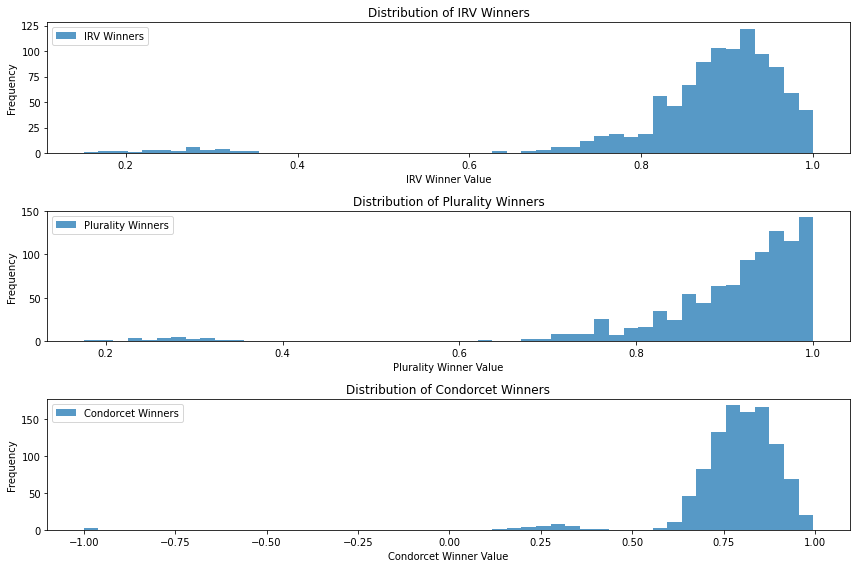

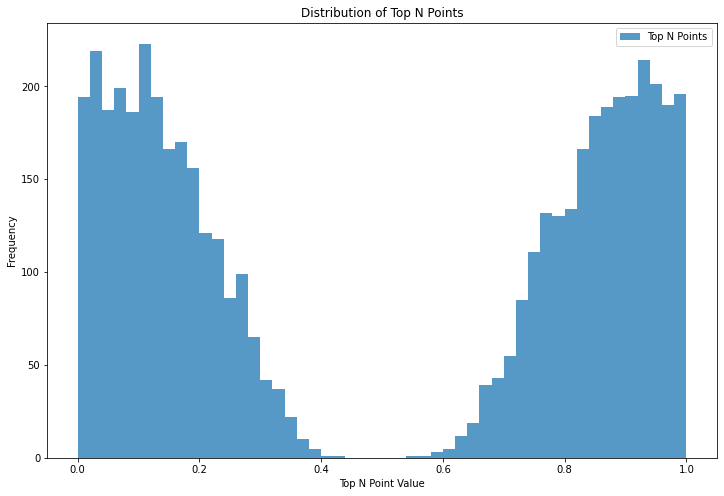

In [356]:
num_runs = 1000
irv_winners = []
plurality_winners = []
condorcet_winners = []
top_n_points_list = []

for _ in range(num_runs):
    irv_winner, plurality_winner, condorcet_winner, top_n_points = top_n(5)
    irv_winners.append(irv_winner)
    plurality_winners.append(plurality_winner)
    condorcet_winners.append(condorcet_winner)
    top_n_points_list.extend(top_n_points)


plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
plt.hist(irv_winners, bins=50, alpha=0.75, label='IRV Winners')
plt.xlabel('IRV Winner Value')
plt.ylabel('Frequency')
plt.title('Distribution of IRV Winners')
plt.legend()

plt.subplot(3, 1, 2)
plt.hist(plurality_winners, bins=50, alpha=0.75, label='Plurality Winners')
plt.xlabel('Plurality Winner Value')
plt.ylabel('Frequency')
plt.title('Distribution of Plurality Winners')
plt.legend()

plt.subplot(3, 1, 3)
plt.hist(condorcet_winners, bins=50, alpha=0.75, label='Condorcet Winners')
plt.xlabel('Condorcet Winner Value')
plt.ylabel('Frequency')
plt.title('Distribution of Condorcet Winners')
plt.legend()

plt.tight_layout()
plt.show()

# Plot distribution of top_n_points
plt.figure(figsize=(12, 8))
plt.hist(top_n_points_list, bins=50, alpha=0.75, label='Top N Points')
plt.xlabel('Top N Point Value')
plt.ylabel('Frequency')
plt.title('Distribution of Top N Points')
plt.legend()
plt.show()